# LLM Experiment Tracking with Neptune in AWS SageMaker

AWS SageMaker is a comprehensive machine learning service that provides every developer and data scientist with the ability to build, train, and deploy machine learning models quickly. When it comes to reliable and standardized experiment tracking, SageMaker users reportedly have been facing some limitations, such as:

* Rigid metadata structure
* Lack of advanced visualization and comparison tools for experiment runs
* Limited native support for dataset and model versioning

This sample notebook shows an example of how one can easily integrate Neptune, full-fledged scalable experiment tracker, to your existing SageMaker component.

# Integration Overview

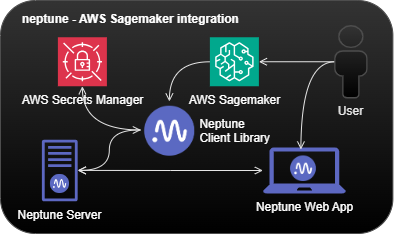

Neptune integrates with your existing setup by connecting *AWS SageMaker* and Neptune services through the Neptune Client Library, a Python-based open source suite of libraries.

Your team will use the *Neptune Web App*, a straightforward UI to the logged metadata. It's where you can have the data visualized, sorted, and organized.
You can watch the training live and, if needed, stop runs remotely. You can also browse tracebacks, system metrics, and source code.
https://docs.neptune.ai/about/app/

The *Neptune Server* centralizes all your model lifecycle artifacts and experiment data, simplifying tracking and retrieval. This ensures your models and experiments are well-documented and easily accessible.

During pipeline execution in SageMaker, you can use the Neptune client library to start an experiment and track its progress.
* For instance, using the `neptune.init()` command, you can initialize a new experiment, and with `neptune.log_metric()` or `neptune.log_artifact()`, you can track metrics and log artifacts directly from your SageMaker scripts.  

For data storage, Neptune offers both SaaS and self-hosted options. In the SaaS model, data is stored securely in *Neptune Server* on Neptune's cloud infrastructure, compliant with industry standards. If you have stricter requirements, the self-hosted option allows you to deploy Neptune within your own infrastructure, ensuring complete control over your data.


# Prerequisites

* [Create your Neptune project](https://docs.neptune.ai/setup/creating_project/)
* [Set up Neptune credentials in AWS Secrets](https://docs.neptune.ai/integrations/sagemaker/setting_up_aws_secret/)
* [Install the neptune-aws integration package](https://docs.neptune.ai/integrations/aws/)
* Confirm that you have the latest version of the SageMaker Python SDK

In [ ]:
%pip install -U "neptune[aws]"

%pip install --quiet --upgrade sagemaker

# Step 1. Deploy a large Language Model (LLM).

First, let's deploy the model that is required to perform the demo. We will use SageMaker JumpStart, an ML models hub. For the purposes of the leight-weight demo, we will use [Flan Large T5 model](https://huggingface.co/google/flan-t5-large) from the Hugging Face. This model excels at various natural language processing (NLP) tasks such as text generation, translation, summarization, and question answering.
For other models available, refer to [Pre-trained Model Table](https://sagemaker.readthedocs.io/en/stable/doc_utils/pretrainedmodels.html).

In [ ]:
import sagemaker
import sagemaker.jumpstart.model as model
import boto3
import time

role_arn = "arn:aws:iam::211125672523:role/service-role/AmazonSageMaker-ExecutionRole-20240526T130826"  # Adjust for your Sagemaker resource role.
boto3.setup_default_session(region_name='eu-north-1')  # Adjust as needed.

model_id, model_version = "huggingface-text2text-flan-t5-large", "2.*"
endpoint_name = f"{model_id}-endpoint"
instance_type = "ml.c5.xlarge"

model = model.JumpStartModel(
    model_id=model_id, model_version=model_version, role=role_arn
)


In [ ]:
predictor = model.deploy(
    endpoint_name=endpoint_name, instance_type=instance_type
)

print(f"Model with endpoint {endpoint_name} has been deployed.")

In case we need to re-start kernel, we can initialize predictor using an existing endpoint, without re-deploying it again.

In [ ]:
from sagemaker.predictor import Predictor
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer

predictor = Predictor(
    endpoint_name=endpoint_name,
    serializer=JSONSerializer(),
    deserializer=JSONDeserializer()
)

# Step 2. Generate a simple prompt with context.

As next, we illustarte the value of the Retrieval-Augmented Generation (RAG) in solving question-answering problems with LLMs.
Consider asking an LLM a specific question about your documentation without any context. The response will be incorrect due to the lack of relevant information. By enhancing the prompt with detailed contextual information, the LLM can provide more accurate and meaningful answers.

In [ ]:
import json

question = "How long should be my password if I use Credential Service Provider?"

payload = {
    "inputs": question,
    "parameters": {
        "max_new_tokens": 512,
        "top_p": 0.9,
        "temperature": 0.1
    },
}
response = predictor.predict(payload, custom_attributes="accept_eula=false")
print(f"LLM response without context: {response}")

LLM response without context: [{'generated_text': '128 characters'}]


In [ ]:
context = """The latest NIST (National Institute of Standards and Technology) password security guidelines, recommend the following key practices when it comes to password length:
Memorized secrets SHALL be at least 8 characters in length if chosen by the subscriber.
Memorized secrets chosen randomly by the Credential Service Provider (CSP) or verifier SHALL be at least 6 characters in length and MAY be entirely numeric."""

prompt_template = """Answer the following QUESTION based on the CONTEXT given. If you do not know the answer and the CONTEXT doesn't contain the answer truthfully say "I don't know".

CONTEXT:
{context}

QUESTION:
{question}
"""

text_input = prompt_template.replace("{context}", context).replace("{question}", question)
payload = {
    "inputs": text_input,
    "parameters": {
        "max_new_tokens": 512,
        "top_p": 0.9,
        "temperature": 0.1
    },
}
response_with_context = predictor.predict(payload, custom_attributes="accept_eula=false")
print(f"LLM response with context: {response_with_context}")

LLM response with context: [{'generated_text': 'at least 6 characters in length'}]


In the example above, we simulated the RAG approach by explcitily providing LLM the context for a given question. In practice, RAG works by first retrieving relevant documents from a data base based on the input query and then generating an answer using these documents as context.

# Step 3. Start experiment tracking.
Now we are all set to start the first tracking run.

In [ ]:
from neptune.integrations.aws import init_run

run = init_run(
    secret="AmazonSageMaker-neptune-secret",  # Adjust for your AWS secret created.
    region="eu-north-1",
    name="prompt_engineering"
)

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/em-experiments/sample-project/e/SP1-8


We will track prompt engineering artifacts in this example.

Generally, tracking prompt engineering artifacts, including prompts, model responses and evaluation metrics, is valuable for the following reasons:
- **Prevent Detrimental Effects**: Avoid uncontrolled and untraceable prompt changes that can harm the use case.
- **Quantitative Evaluation**: Track and evaluate prompts over time to ensure consistent incremental improvements.
- **Ensure Robust Performance**: Qualitative evaluations are insufficient; comprehensive tracking is needed for reliable performance across larger samples.
- **Balance Incremental Improvements**: Maintain a balance of incremental improvements without adverse effects.
- **Transparent Reporting**: Multiple stakeholders can review and question prompt engineering results, making it essential to maintain a detailed change log.
- **Optimize with Prompt Tuning**: K-shot learning with prompt tuning enhances LLM performance, making prompt tuning a natural first step before full model fine-tuning.

In [ ]:
import pandas as pd
from neptune.types import File

def log_prompt_response(run, df, prompt_version, prompt, response) -> None:
    new_entry = {
        "prompt_version": prompt_version,
        "prompt": prompt,
        "response": response
    }
    df = pd.concat([df, pd.DataFrame([new_entry])], ignore_index=True)
    csv_path = "prompts_responses.csv"
    df.to_csv(csv_path, index=False)

    run["prompt_engineering/prompts_responses"].upload(csv_path)

data = {
    "prompt_version": [],
    "prompt": [],
    "response": []
}

df = pd.DataFrame(data)

prompt_templates = [
    """Answer the following QUESTION based on the CONTEXT given. If you do not know the answer and the CONTEXT doesn't contain the answer truthfully say "I don't know".
    CONTEXT: {context}, QUESTION: {question}""",
    """Answer the following QUESTION based on the CONTEXT given. In addition to answer, provide references when applicable.
    CONTEXT: {context}, QUESTION: {question}""",

]

for i, prompt_template in enumerate(prompt_templates):
    text_input = prompt_template.replace("{context}", context).replace("{question}", question)
    payload = {
    "inputs": text_input,
    "parameters": {
        "max_new_tokens": 512,
        "top_p": 0.9,
        "temperature": 0.1
        },
    }

    response_with_context = predictor.predict(payload, custom_attributes="accept_eula=false")
    response_text = response_with_context[0]["generated_text"]
    print(f"Prompt template: {prompt_template}. Model response: {response_text}")

    # Log to Neptune.
    log_prompt_response(run, df, f"v{i+1}", prompt_template, response_text)

run.stop()

Prompt template: Answer the following QUESTION based on the CONTEXT given. If you do not know the answer and the CONTEXT doesn't contain the answer truthfully say "I don't know".
    CONTEXT: {context}, QUESTION: {question}. Model response: at least 6 characters in length
Prompt template: Answer the following QUESTION based on the CONTEXT given. In addition to answer, provide references when applicable.
    CONTEXT: {context}, QUESTION: {question}. Model response: NIST (National Institute of Standards and Technology) password security guidelines, recommend the following key practices when it comes to password length: Memorized secrets chosen randomly by the Credential Service Provider (CSP) or verifier SHALL be at least 6 characters in length and MAY be entirely numeric.,
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[n

In the example above, we tested several prompt templates, each time logging prompt versions and respective model responses with Neptune experiment run.

# Remarks

- This notebook shows a lightweight demo to kick start your experiment tracking with Neptune.
- To run training jobs with tracking at scale, see this guide to use Neptune in a dockerized solution: [How to use Neptune in SageMaker training jobs](https://docs.neptune.ai/integrations/sagemaker/using_neptune_in_training_jobs/).
- To get some ideas or inspiration from successfully integrated solutions, see the case study of one of the Neptune customers: [Brainly](https://neptune.ai/customers/brainly).
